## Лабораторная работа №2 по СОБД
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML
## Часть 1
## Датасет "NYC Yellow Taxi Trip Data"
### Объём: 6.88 Гб

## Подключение необходимых библиотек

In [3]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt

## Инициализация PySpark и создание сессии

In [4]:
conf = SparkConf()
conf.setAppName("Trip Data Analysis")
conf.setMaster("local[*]")  # Локальный режим (все ядра контейнера)
conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")  # Указываем HDFS

conf.set("spark.driver.memory", "8g")           
conf.set("spark.executor.memory", "6g")         
conf.set("spark.memory.fraction", "0.8")        
conf.set("spark.memory.storageFraction", "0.3")

# Настройки для больших данных
conf.set("spark.sql.adaptive.enabled", "true")
conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
conf.set("spark.sql.adaptive.skew.enabled", "true")
conf.set("spark.sql.shuffle.partitions", "100")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

## Загрузка данных

Прочтём преобразованный датасет из Л/Р №1 в формате .parquest

In [5]:
path = "hdfs:///user/vladislav_vaganov/datasets/parquets/tripdata_cleaned.parquet"
df = spark.read.parquet(path)

Выведем датафрейм на экран

In [6]:
df.limit(20).toPandas().style\
    .set_properties(**{'text-align': 'left', 'max-width': '0', 'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .format(precision=2)

,VendorID,passenger_count,trip_distance,haversine_distance,RateCodeID,payment_type,is_airport_trip,pickup_hour,pickup_dow,total_amount
0,2,4,1.57,1.12,1,2,0,23,3,7.80
1,2,1,2.53,1.89,1,1,0,23,3,14.76
2,2,2,6.47,4.61,1,2,0,23,3,22.80
3,2,1,2.62,2.46,1,1,0,23,3,14.12
4,2,1,1.49,1.06,1,2,0,23,3,11.30
5,2,1,3.31,2.42,1,1,0,23,3,21.36
6,2,5,1.31,1.08,1,2,0,23,3,9.80
7,2,1,1.32,0.96,1,2,0,23,3,8.80
8,2,1,5.63,4.30,1,1,0,23,3,30.36
9,2,1,1.99,1.64,1,1,0,23,3,12.96


Выведем схему данных

In [7]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- haversine_distance: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- is_airport_trip: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_dow: integer (nullable = true)
 |-- total_amount: double (nullable = true)



Вычислим количество строк в датафрейме

In [8]:
df.count()

45543284

## Постановка задачи 

Для датасета, заданного представленными колонками, требуется построить модель градиентного бустинга на деревьях решений для оценки **стоимости поездки** на такси по всем остальным признакам.

Для оценки качества обучения следует использовать метрики $RMSE$ и $R^2$.

## Подготовка и кодирование признаков

Столбец **total_amount** уже имеет **DoubleType**

Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл. Он понадобится в следующей лабораторной работе.

In [9]:
def save_sample_to_csv(data: DataFrame, file_path: str, 
                       sample_size: int = 1000) -> DataFrame:
    """
    Сохраняет первые `sample_size` строк из DataFrame в CSV-файл 
    на драйвере и возвращает DataFrame с оставшимися данными.

    Args:
        data (DataFrame): DataFrame, из которого нужно извлечь
            строки.
        file_path (str): Путь для сохранения CSV-файла.
        sample_size (int): Количество строк для сохранения
            (по умолчанию 1000).

    Returns:
        DataFrame: DataFrame с оставшимися данными.
    """
    # Определяем пропорции для разделения
    sample_fraction = sample_size / data.count()
    remaining_fraction = 1 - sample_fraction

    # Разделяем DataFrame на два непересекающихся набора данных
    sample_data, remaining_data = data.randomSplit(
        [sample_fraction, remaining_fraction]
    )

    # Сохраняем извлеченные строки в CSV-файл на драйвере
    try:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.writer(file)

            # Записываем заголовок
            writer.writerow(data.columns)

            # Записываем строки
            for row in sample_data.take(sample_size):
                writer.writerow(row)
        print(f"Файл \"{file_path}\" с данными успешно создан.")

    except Exception as e:
        print(f"Ошибка при записи файла: {e}")

    return remaining_data

Определяем путь для сохранения csv-файла.

In [10]:
path = "tripdata.csv"
df = save_sample_to_csv(data=df, file_path=path, sample_size=1000)

Ошибка при записи файла: An error occurred while calling o63.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 10.0 failed 1 times, most recent failure: Lost task 0.0 in stage 10.0 (TID 37) (864eda11676d executor driver): java.lang.IllegalArgumentException: Comparison method violates its general contract!
	at org.apache.spark.util.collection.TimSort$SortState.mergeHi(TimSort.java:910)
	at org.apache.spark.util.collection.TimSort$SortState.mergeAt(TimSort.java:519)
	at org.apache.spark.util.collection.TimSort$SortState.mergeCollapse(TimSort.java:445)
	at org.apache.spark.util.collection.TimSort$SortState.access$200(TimSort.java:308)
	at org.apache.spark.util.collection.TimSort.sort(TimSort.java:136)
	at org.apache.spark.util.collection.Sorter.sort(Sorter.scala:37)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeInMemorySorter.getSortedIterator(UnsafeInMemorySorter.java:367)
	at org.apache.spark.util.collection.unsafe.sort.Unsafe

Оцениваем, сколько строк в датасете осталось.

In [11]:
df.count()

45542291

Разделим датасет на обучающую и тестовую выборки.

In [12]:
df = df.limit(5000000)

In [13]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [14]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 4000780
Test  dataset size: 999220


Исходя из построенной корреляционной матрицы в Л/Р №1 ясно, что признаки [**VendorID**, **passenger_count**, **pickup_hour**, **pickup_dow**] не оказывают прямого и значимого влияния на **total_amount**. Использовать их в модели нет смысла.

Остальные признаки сгруппируем по их типам:

**Категориальные** признаки закодируем с помощью `Label Encoding`.

**Бинарные** признаки представлены значениями `0` / `1`. Поэтому, в кодировании не нуждаются.

**Количественные** признаки нужно нормализовать / стандартизировать, перед тем, как передавать их в модель.

In [16]:
# Категориальные признаки
categorical_features = ["RateCodeID", "payment_type"]

# Бинарные признаки
binary_features = ["is_airport_trip"]

# Количественные признаки
numeric_features = ["trip_distance", "haversine_distance"]

# ИСКЛЮЧАЕМЫЕ признаки
excluded_features = ["VendorID", "passenger_count", "pickup_hour", "pickup_dow"]

Создадим конвейер обработки данных, включающий модель линейной регрессии.

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor

def create_pipeline(categorical_features: list[str], 
                   numeric_features: list[str], 
                   binary_features: list[str], 
                   label_col: str, 
                   max_iter: int) -> Pipeline:
    """
    Создает конвейер для обработки данных и обучения модели градиентного бустинга для регрессии.

    Args:
        categorical_features: Список категориальных признаков.
        numeric_features: Список количественных признаков.
        binary_features: Список бинарных признаков.
        label_col: Название столбца с меткой.
        max_iter: Максимальное количество итераций для модели.

    Returns:
        Pipeline: Конвейер для обработки данных и обучения модели.
    """
    stages = []
    
    # Этап 1: Label Encoding для категориальных признаков
    if categorical_features:
        indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
        string_indexer = StringIndexer(
            inputCols=categorical_features,
            outputCols=indexed_categorical_features,
            handleInvalid="keep"
        )
        stages.append(string_indexer)
        
        # Используем индексированные версии категориальных признаков
        features_for_assembler = indexed_categorical_features
    else:
        features_for_assembler = []
    
    # Добавляем бинарные и количественные признаки
    features_for_assembler.extend(binary_features)
    features_for_assembler.extend(numeric_features)
    
    # Этап 2: Сбор всех признаков в один вектор
    vector_assembler = VectorAssembler(
        inputCols=features_for_assembler,
        outputCol="features"
    )
    stages.append(vector_assembler)
    
    # Этап 3: Модель градиентного бустинга для регрессии
    gbt_regressor = GBTRegressor(
        featuresCol="features",
        labelCol=label_col,
        predictionCol="prediction",
        maxIter=max_iter,
        maxDepth=5,
        stepSize=0.1,
        seed=42
    )
    stages.append(gbt_regressor)
    
    # Создаем конвейер
    pipeline = Pipeline(stages=stages)

    return pipeline

# Создаем пайплайн для ваших данных
pipeline = create_pipeline(
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    binary_features=binary_features,
    label_col="total_amount",
    max_iter=100
)

print("\nКонвейер успешно создан!")


Конвейер успешно создан!


## Обучение модели

Выполним подбор **гиперпараметров** модели градиентного бустинга на деревьях решений с помощью кросс-валидации на сетке.

In [18]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Создаем сетку параметров для GBT регрессии
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].maxIter, [50]) \
    .addGrid(pipeline.getStages()[-1].maxDepth, [5]) \
    .addGrid(pipeline.getStages()[-1].stepSize, [0.1, 0.15]) \
    .build()

Создаем экземпляр **RegressionEvaluator** для оценки модели.

In [19]:
evaluator = RegressionEvaluator(
    labelCol="total_amount",
    predictionCol="prediction", 
    metricName="rmse"
)

Создаем объект **CrossValidator**.

In [20]:
crossval = CrossValidator(estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    parallelism=4,                   
    numFolds=2)

Обучаем модель конвейера с использованием кросс-валидации.

In [21]:
cv_model = crossval.fit(train_df)

Выведем параметры лучшей модели, определенной в ходе кросс-валидации.

In [23]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей GBT модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей GBT модели.
    """
    best_model = cv_model.bestModel
    gbt_model = best_model.stages[-1]  # GBTRegressor - последняя стадия пайплайна
    
    best_params = {
        "maxIter": gbt_model.getMaxIter(),
        "maxDepth": gbt_model.getMaxDepth(),
        "stepSize": gbt_model.getStepSize(),
    }
    return best_params

print("Параметры лучшей GBT модели:")
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"  {key}: {value}")

Параметры лучшей GBT модели:
  maxIter: 50
  maxDepth: 5
  stepSize: 0.15


## Анализ процесса обучения

Визуализируем изменение ошибки модели в ходе обучения и рассчитаем метрики на обучающем датасете.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gbt_training_metrics(cv_model: CrossValidatorModel, test_data: DataFrame) -> None:
    """
    Анализ метрик GBTRegressor на тестовой выборке и важность признаков.
    """
    # Делаем предсказания на тестовой выборке
    test_predictions = cv_model.transform(test_data)
    
    # Вычисляем метрики
    rmse_evaluator = RegressionEvaluator(labelCol="total_amount", 
                                        predictionCol="prediction", 
                                        metricName="rmse")
    r2_evaluator = RegressionEvaluator(labelCol="total_amount", 
                                      predictionCol="prediction", 
                                      metricName="r2")
    mae_evaluator = RegressionEvaluator(labelCol="total_amount", 
                                       predictionCol="prediction", 
                                       metricName="mae")
    
    test_rmse = rmse_evaluator.evaluate(test_predictions)
    test_r2 = r2_evaluator.evaluate(test_predictions)
    test_mae = mae_evaluator.evaluate(test_predictions)
    
    print("МЕТРИКИ GBTRegressor:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"R²: {test_r2:.4f}")
    
    # Визуализируем важность признаков
    best_model = cv_model.bestModel
    gbt_model = best_model.stages[-1]
    
    # Получаем важность признаков
    feature_importance = gbt_model.featureImportances
    
    # Определяем имена признаков (в порядке их добавления в VectorAssembler)
    feature_names = [
        "RateCodeID_index",    # из categorical_features
        "payment_type_index",  # из categorical_features  
        "is_airport_trip",     # из binary_features
        "trip_distance",       # из numeric_features
        "haversine_distance"   # из numeric_features
    ]
    
    # Создаем DataFrame с важностью признаков
    importance_list = []
    for i, name in enumerate(feature_names):
        importance_list.append({
            'feature': name,
            'importance': feature_importance[i]
        })
    
    importance_df = pd.DataFrame(importance_list)
    importance_df = importance_df.sort_values('importance', ascending=True)
    
    # Строим график
    plt.figure(figsize=(12, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], 
             color='skyblue', edgecolor='black', alpha=0.8)
    plt.xlabel('Важность признака')
    plt.title(f'GBTRegressor - Важность признаков\nTest RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}')
    plt.grid(axis='x', alpha=0.3)
    
    # Добавляем значения важности на график
    for i, (feature, importance) in enumerate(zip(importance_df['feature'], importance_df['importance'])):
        plt.text(importance, i, f' {importance:.4f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

МЕТРИКИ GBTRegressor:
RMSE: 2.6038
R²: 0.9357


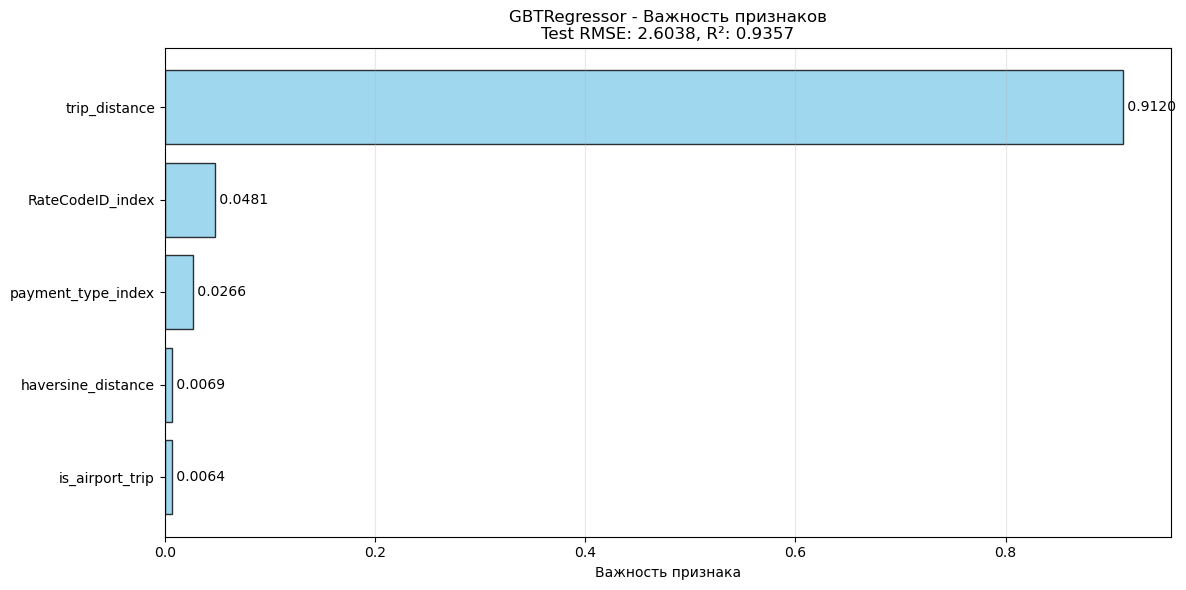

In [25]:
plot_gbt_training_metrics(cv_model, test_df)

## Проверка обобщающей способности модели

Выполним предсказания на тестовой выборке

In [26]:
test_df_predictions = cv_model.transform(test_df)

right_columns_order = test_df_predictions.columns
right_columns_order.remove("total_amount")
right_columns_order.append("total_amount")

test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.limit(20).toPandas().style\
    .set_properties(**{'text-align': 'left', 'max-width': '0', 'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .format(precision=2)

,VendorID,passenger_count,trip_distance,haversine_distance,RateCodeID,payment_type,is_airport_trip,pickup_hour,pickup_dow,RateCodeID_index,payment_type_index,features,prediction,total_amount
0,1,1,0.10,0.00,1,2,0,0,5,0.00,1.00,"[0.0,1.0,0.0,0.1,0.00047851614142336375]",4.74,3.80
1,1,1,0.10,0.00,1,2,1,11,3,0.00,1.00,"[0.0,1.0,1.0,0.1,0.0008422303405430034]",4.20,3.30
2,1,1,0.10,0.00,2,2,0,5,1,1.00,1.00,"[1.0,1.0,0.0,0.1,0.0011249845428157239]",53.90,52.80
3,1,1,0.10,0.00,1,2,0,10,4,0.00,1.00,"[0.0,1.0,0.0,0.1,0.0015974973983353328]",4.74,3.80
4,1,1,0.10,0.00,5,2,0,20,5,2.00,1.00,"[2.0,1.0,0.0,0.1,0.002844439438569964]",7.94,0.30
5,1,1,0.10,0.00,1,1,0,0,3,0.00,0.00,"(5,[3,4],[0.1,0.003023974496617887])",6.04,3.80
6,1,1,0.10,0.00,1,2,0,11,1,0.00,1.00,"[0.0,1.0,0.0,0.1,0.0035629447782850815]",4.74,3.30
7,1,1,0.10,0.01,1,2,0,19,3,0.00,1.00,"[0.0,1.0,0.0,0.1,0.00659849074413326]",4.74,4.30
8,1,1,0.10,0.01,1,2,0,13,1,0.00,1.00,"[0.0,1.0,0.0,0.1,0.006931336328650254]",4.74,3.30
9,1,1,0.10,0.01,1,2,0,1,1,0.00,1.00,"[0.0,1.0,0.0,0.1,0.008159860098781547]",4.74,3.80


Создадим функцию оценки модели: расчета метрик для некоторого датасета, как правило, тестового.

In [27]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").

    Returns:
        float: Значение указанной метрики.
    """
    evaluator = RegressionEvaluator(labelCol="total_amount", 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    return metric_value

Оценим модель на тестовой выборке.

In [28]:
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE на тестовых данных: {test_rmse:.4f}")
print(f"R² на тестовых данных: {test_r2:.4f}")

RMSE на тестовых данных: 2.6038
R² на тестовых данных: 0.9357


## Сохранение модели

Зададим директорию, в которой будет сохранена обученная модель.

In [29]:
model_path = "hdfs:///user/vladislav_vaganov/datasets/gbt_taxi_model"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.write().overwrite().save(model_path)
    print(f"Модель успешно сохранена в: {model_path}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель успешно сохранена в: hdfs:///user/vladislav_vaganov/datasets/gbt_taxi_model


In [30]:
spark.stop()